https://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/coregionalized_regression_tutorial.ipynb

In [2]:
%pylab inline
import pylab as pb
pylab.ion()
import GPy

Populating the interactive namespace from numpy and matplotlib


In [3]:
f_output1 = lambda x: 4. * np.cos(x/5.) - .4*x - 35. + np.random.rand(x.size)[:,None] * 2
f_output2 = lambda x: 6. * np.cos(x/5) + .2*x + 35. + np.random.rand(x.size)[:,None] * 8.

# {X,Y} training set for each output
X1 = np.random.rand(100)[:,None]; X1=X1*75
X2 = np.random.rand(100)[:,None]; X2=X2*70 + 30
Y1 = f_output1(X1)
Y2 = f_output2(X2)
# {X,Y} test set for each output
Xt1 = np.random.rand(100)[:,None]*100
Xt2 = np.random.rand(100)[:,None]*100
Yt1 = f_output1(Xt1)
Yt2 = f_output2(Xt2)

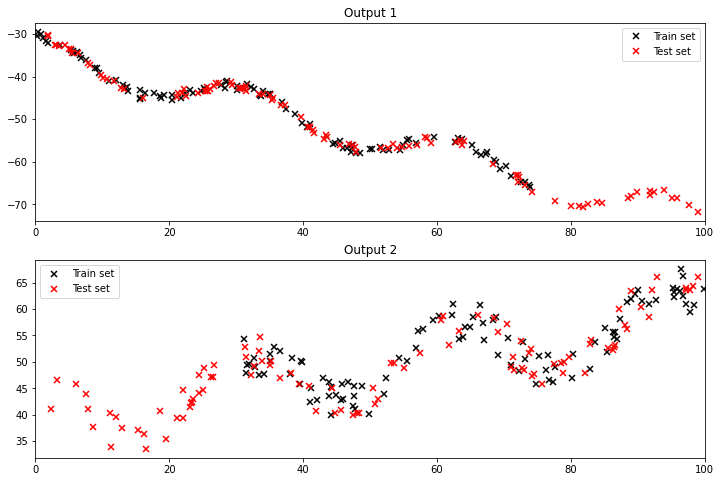

In [5]:
xlim = (0,100); ylim = (0,50)
fig = pb.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1.set_xlim(xlim)
ax1.set_title('Output 1')
ax1.plot(X1[:,:1],Y1,'kx',mew=1.5,label='Train set')
ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5,label='Test set')
ax1.legend()
ax2 = fig.add_subplot(212)
ax2.set_xlim(xlim)
ax2.set_title('Output 2')
ax2.plot(X2[:,:1],Y2,'kx',mew=1.5,label='Train set')
ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5,label='Test set')
ax2.legend();

In [7]:
def plot_2outputs(m,xlim,ylim):
    fig = pb.figure(figsize=(12,8))
    #Output 1
    ax1 = fig.add_subplot(211)
    ax1.set_xlim(xlim)
    ax1.set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,100),ax=ax1)
    ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5)
    #Output 2
    ax2 = fig.add_subplot(212)
    ax2.set_xlim(xlim)
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(100,200),ax=ax2)
    ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5)

# Covariance Kernel

The coregionalized regression model relies on the use of multiple output kernels or vector-valued kernels, of the following form:

$$\begin{align*}
{\bf B}\otimes{\bf K} = 
\left(\begin{array}{ccc}
B_{1,1}\times{\bf K}({\bf X}_{1}, {\bf X}_{1}) & \ldots &
B_{1,D}\times{\bf K}({\bf X}_{1}, {\bf X}_{D}\\
\vdots & \ddots\\
B_{D, 1}\times{\bf K}({\bf X}_{D}, {\bf X}_{1}) & \ldots &
B_{D, D}\times{\bf K}({\bf X}_{D}, {\bf X}_{D})
\end{array}\right)
\end{align*}$$

In the expression above, $\bf{K}$ is a kernel function, $\bf{B}$ is regarded as the coregionalization matrix, and $\bf{X}_i$ represents the inputs corresponding to the $i$-th output. 

In GPy, a multiple output kernel is defined in the following way.

In [8]:
import GPy
K = GPy.kern.RBF(1)
B = GPy.kern.Coregionalize(input_dim=1, output_dim=2)
multkernel = K.prod(B, name='B.K')
print(multkernel)

  B_K.             |   value  |  constraints  |  priors
  rbf.variance     |     1.0  |      +ve      |        
  rbf.lengthscale  |     1.0  |      +ve      |        
  coregion.W       |  (2, 1)  |               |        
  coregion.kappa   |    (2,)  |      +ve      |        


The components of the kernel can be accessed as follows:

In [9]:
# Components of B
print('W matrix\n', B.W)
print('\nkappa vector\n', B.kappa)
print('\nB matrix\n', B.B)

W matrix
   index  |  coregion.W  |  constraints  |  priors
  [0 0]  |  0.60730649  |               |        
  [1 0]  |  0.33507089  |               |        

kappa vector
   index  |  coregion.kappa  |  constraints  |  priors
  [0]    |      0.50000000  |      +ve      |        
  [1]    |      0.50000000  |      +ve      |        

B matrix
 [[0.86882117 0.20349072]
 [0.20349072 0.6122725 ]]


The function below defined two kernels and multiply them together.

In [10]:
icm = GPy.util.multioutput.ICM(input_dim=1, num_outputs=2, kernel=GPy.kern.RBF(1))

# Using the GPy's Coregionalized Regression Model

Once we have defined an appropriate kernel for our model, its use is straightforward. In the next example we will use a Matern-3/2 kernel as K.


Name : gp
Objective : 377.0727800795222
Number of Parameters : 8
Number of Optimization Parameters : 7
Updates : True
Parameters:
  gp.                                    |                value  |  constraints  |  priors
  ICM.Mat32.variance                     |                  1.0  |   +ve fixed   |        
  ICM.Mat32.lengthscale                  |   204.84151587705358  |      +ve      |        
  ICM.B.W                                |               (2, 1)  |               |        
  ICM.B.kappa                            |                 (2,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |  0.35348121580810726  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |    5.117487156523123  |      +ve      |        


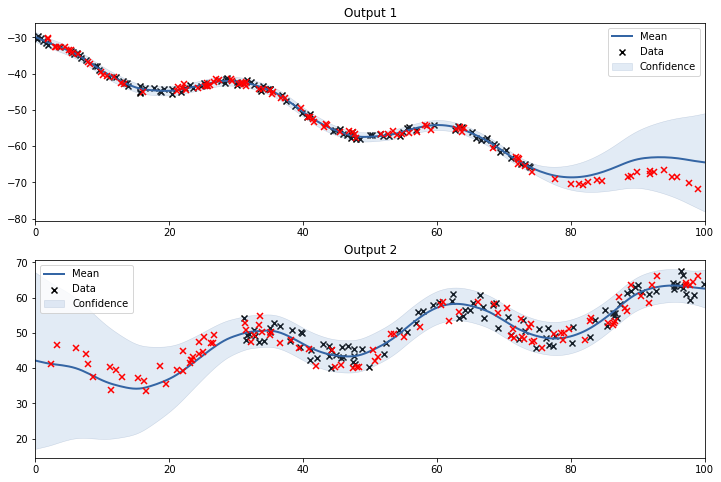

In [11]:
K = GPy.kern.Matern32(1)
icm = GPy.util.multioutput.ICM(input_dim=1, num_outputs=2, kernel=K)

m = GPy.models.GPCoregionalizedRegression([X1,X2],[Y1,Y2], kernel=icm)
m['.*Mat32.var'].constrain_fixed(1.)
m.optimize()
print(m)
plot_2outputs(m, xlim=(0, 100), ylim=(-20, 60))

Notice that there are two parameters for the noise variance. Each one corresponds to the noise of each output.

But what is the advantage of this model? Well, the fit of a non-coregionalized model (i.e. two independent models) would look like

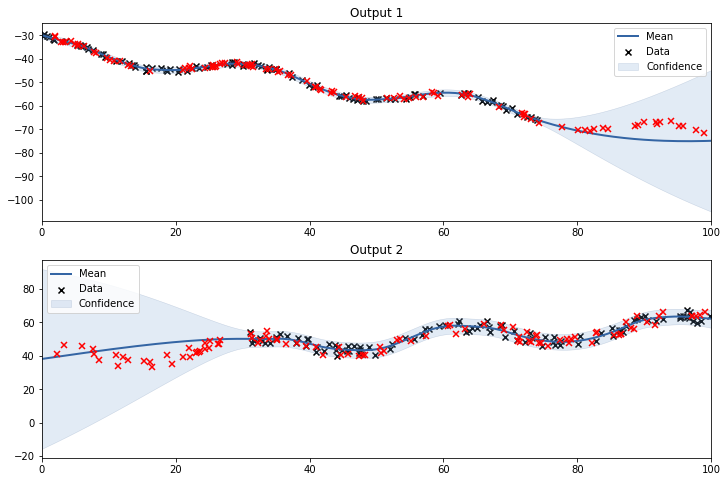

In [13]:
K = GPy.kern.Matern32(1)

m1 = GPy.models.GPRegression(X1,Y1,kernel=K.copy())
m1.optimize()
m2 = GPy.models.GPRegression(X2,Y2,kernel=K.copy())
m2.optimize()
fig = pb.figure(figsize=(12,8))
#Output 1
ax1 = fig.add_subplot(211)
m1.plot(plot_limits=xlim,ax=ax1)
ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5)
ax1.set_title('Output 1')
#Output 2
ax2 = fig.add_subplot(212)
m2.plot(plot_limits=xlim,ax=ax2)
ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5)
ax2.set_title('Output 2');

The coregionalized model shares information across outputs, but the independent models cannot do that. In the regions where there is no training data specific to an output the independent models tend to return to the prior assumptions. In this case, where both outputs have associated patterns, the fit is better with the coregionalized model.

Can we improve the fit in the coregionalization? Yes, we will have a look at that in the next section.

# Kernel selection

The data from both outputs is not centered on zero. A way of dealing with outputs of different means or magnitudes is using a bias kernel.

This kernel is just changing the mean (constant) of the Gaussian Process being fitted. There is no need to assume any sort of correlation between both means, so we define W=0.

In [1]:
kernel = GPy.util.multioutput.ICM(input_dim=1,num_outputs=2,kernel=GPy.kern.Bias(input_dim=1))
m = GPy.models.GPCoregionalizedRegression(X_list=[X1,X2],Y_list=[Y1,Y2],kernel=kernel)
m['.*bias.var'].constrain_fixed(1) #B.kappa now encodes the variance.
m['.*W'].constrain_fixed(0)
m.optimize()
plot_2outputs(m,xlim=(-20,120),ylim=(0,60))

NameError: name 'GPy' is not defined

At the moment, our model is only able to explain the mean of the data. However we can notice that there is a decreasing trend in the first output and increasing trend in the second one. In this case we can model such a trend with a linear kernel.

Since the linear kernel only fits a line with constant slope along the output space, there is no need to assume any correlation between outpus. 

We could define our new multiple output kernel as follows:

$${\bf K}_{ICM} = {\bf B} \otimes ({\bf K}_{bias} + {\bf K}_{linear})$$

However, we can also define a more general kernel of the following form:

$${\bf K}_{LCM} = {\bf B}_1 \otimes {\bf K}_{bias} + {\bf B}_2 \otimes {\bf K}_{linear}$$

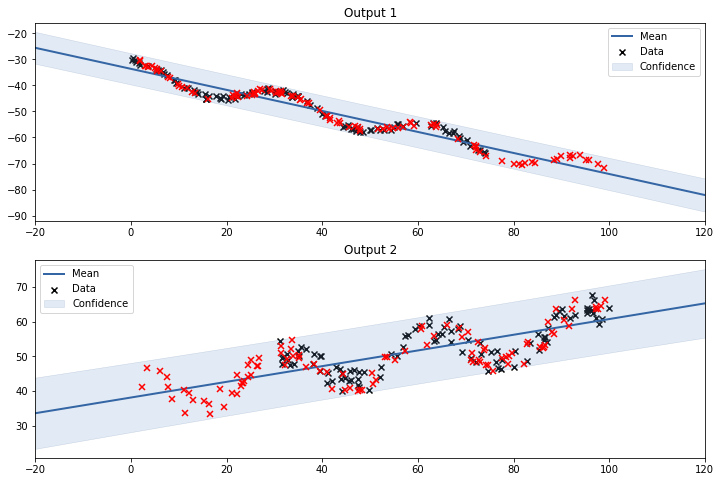

In [17]:
K1 = GPy.kern.Bias(1)
K2 = GPy.kern.Linear(1)
lcm = GPy.util.multioutput.LCM(input_dim=1, num_outputs=2, kernels_list=[K1,K2])

m = GPy.models.GPCoregionalizedRegression([X1,X2], [Y1,Y2], kernel=lcm)
m['.*bias.var'].constrain_fixed(1.)
m['.*W'].constrain_fixed(0)
m['.*linear.var'].constrain_fixed(1.)
m.optimize()
plot_2outputs(m, xlim=(-20, 120), ylim=(0,60))

Now we will model the variation along the trend defined by the linear component. We will do this with a Matern-3/2 kernel.

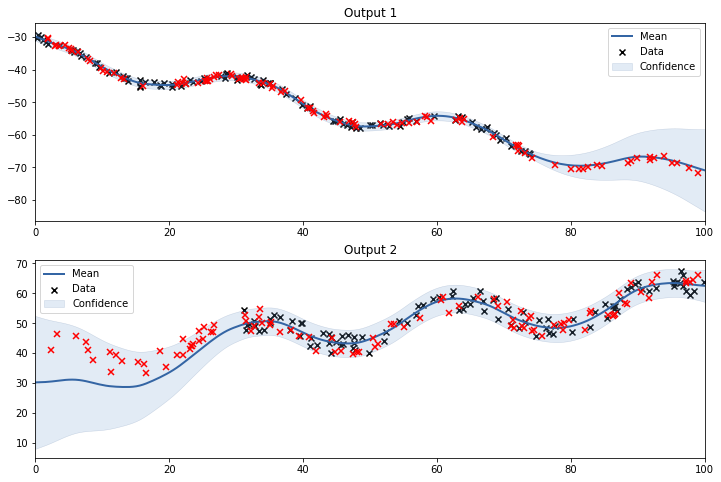

In [18]:
K1 = GPy.kern.Bias(1)
K2 = GPy.kern.Linear(1)
K3 = GPy.kern.Matern32(1)
lcm = GPy.util.multioutput.LCM(input_dim=1, num_outputs=2, kernels_list=[K1, K2, K3])

m = GPy.models.GPCoregionalizedRegression([X1,X2], [Y1,Y2], kernel=lcm)
m['.*ICM.*var'].unconstrain()
m['.*ICM0.*var'].constrain_fixed(1.)
m['.*ICM0.*W'].constrain_fixed(0)
m['.*ICM1.*var'].constrain_fixed(1.)
m['.*ICM1.*W'].constrain_fixed(0)
m.optimize()
plot_2outputs(m,xlim=(0,100),ylim=(-20,60))

# Prediction at new input values

Behind the scenes, this model is using an extended input space with and additional dimension that points at the output each data point belongs to. To make use of the prediction function of GPy, this model needs the input array to have the extended format.

For example if we want to make predictions in the region 100 to 100 for the second output, we need to define the new inputs as follows:

In [19]:
newX=np.arange(100, 110)[:,None]
newX = np.hstack([newX, np.ones_like(newX)])
print(newX)

[[100   1]
 [101   1]
 [102   1]
 [103   1]
 [104   1]
 [105   1]
 [106   1]
 [107   1]
 [108   1]
 [109   1]]


We also need to pass another output to the predict function. This is an array that tells which $\color{firebrick}{\textbf{noise model}}$ is associated to each point to be predicted. This is a dictionary constructed as follows:

In [20]:
noise_dict = {'output_index':newX[:,1:].astype(int)}

The astype(int) function is to ensure that the values of the dictionary are integers, otherwise the Python complains when using them as indices. Then prediction is command can then be called this way:

In [21]:
m.predict(newX,Y_metadata=noise_dict)

(array([[62.48703376],
        [62.2875095 ],
        [62.08401556],
        [61.87667316],
        [61.66560123],
        [61.45091642],
        [61.23273316],
        [61.01116367],
        [60.78631803],
        [60.55830419]]),
 array([[ 7.55316091],
        [ 9.56406715],
        [12.68609401],
        [17.14249691],
        [23.13898908],
        [30.86459251],
        [40.49245509],
        [52.18063515],
        [66.07285459],
        [82.2992217 ]]))

In the case of the coregionalized model, each output is automatically assigned a specific Gaussian noise parameter. However, GPy is flexible enough to do more crazy stuff. Think about using an heteroscedastic noise model for each output... Not straightforward, at the moment, but the pieces are in place to handle it.

We can even use different models, not only Gaussian noise. For example, Bernoulli noise or Poisson noise... but that is part of a future notebook. 